# Introduction
The goal of the project is to detect red barrels in a given image. To achieve this some trainset is given and first the data needs to be labeled (red barrel, red non-barrel, and other). Also it predicts the distance of the barrel from the camera (where linear regression is used for estimating the distance).

# Labeling data to different classes
In order to label the images to 3 different classes (red barrel, red nonbarrel, other) an 3rd party library (https://github.com/jdoepfert/roipoly.py) is used (roipoly) which uses matplot lib backend to draw polygon region of interest.
First we import all the necessary functions and define all tne directories that the testdata is located as well as the directory where we want the feature for each class to be saved; the feature for each class is 3 by number of pixels (which varies for each class) matrix (3 for rgb values).

In [1]:
import pylab as pl

from roipoly import roipoly

import os
import cv2
import time
import numpy as np
import itertools


mask_name = "_redbarrel" # Note: mask name needs to be changed according to the class of interest 
curr_directory = os.curdir
direct_to_images = curr_directory + "/trainset/"
direct_to_masked_images = curr_directory + "/mask" + mask_name + "/"
images_names = os.listdir(direct_to_images)
train_image_names = images_names[0:int(len(images_names)*0.8)]
test_image_names = images_names[int(len(images_names)*0.8):-1]

Now define a function which takes the image and a mask produced by riopoly (based on selected region) and gives the rgb value of all the pixels in the region where the mask is non-zero.

In [2]:
def image_to_features(image, mask):
    x, y = np.nonzero(mask)
    feature = image[x,y,:]
    feature = np.transpose(feature)
    return feature

The last part for labeling is just looping through the train images and then choose the desired class pixels (drawing a region around it) using roipoly and then then create a feature for the specific class and append all the features as we go thorugh all the trainset images (Note for each image there is infinite amount of chances to draw desired region in order to specify the pixels for each class completely). The code below goes through the steps in order to acheive the goal but it needs to be executed outsied jupyter notebook since the interactive mode does not really work on notebook (needs further investigation). 

./trainset/7.2.png


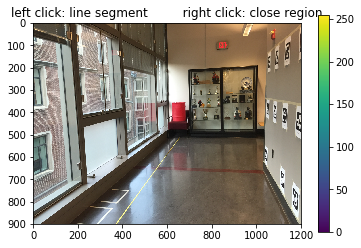

NameError: name 'r_channel' is not defined

In [6]:
flag = 0;
for image_name in train_image_names:

    print(direct_to_images+image_name)
    image = cv2.imread(direct_to_images+image_name)
    image = image[:,:,::-1]
    count = 0
    while 1:

        fig = pl.figure()
        pl.subplot(111)

        pl.imshow(image, interpolation='nearest')
        pl.colorbar()

        pl.title("left click: line segment         right click: close region")
        MyROI = roipoly(roicolor='r')
        pl.close(fig)
        if len(MyROI.allxpoints) < 4:
            break
            
        mask = MyROI.getMask(image[:,:,1])
        feature = image_to_features(image, mask)
        if flag == 0:
            features_all = feature
            flag = 1
        else:
            features_all = np.concatenate((features_all,feature),axis=1)
        r_channel = image[:,:,0]* np.bool_(mask)
        g_channel = image[:,:,1]* np.bool_(mask)
        b_channel = image[:,:,2]* np.bool_(mask)
        mask = 1*mask
        np.save(direct_to_masked_images + image_name.replace(".png", "") +  "_" + str(count), mask)
        count += 1
    img_masked = cv2.merge([r_channel, g_channel, b_channel])
    cv2.imwrite(image_name.replace(".png","") + mask_name + ".png", img_masked)



np.save(direct_to_masked_images+ "features_train" + mask_name, features_all)



# Finding Class Parameters (Mean, Covariance, Class Probabilities)
After the classes have been identified, we will need to learn class parameters in order to use Bayes Decision Rule to determine the redbarrel for each given image. 

In [7]:
from roipoly import roipoly
from collections import defaultdict
import pylab as pl
import os
import cv2
import time
import numpy as np
import math
import itertools
from skimage.measure import regionprops
from skimage.measure import label
import scipy.misc


curr_directory = os.curdir
x_hat = np.load(curr_directory+"/x_hat_dist.npy")
direct_to_classes = curr_directory + "/classes_data/"


The following function is written to calculate the parameters.

Note that in order to have a faster run time when calculating the likelihood (i.e. avoiding for loop for each pixel) following strategy is used:

The main idea is that $$a^TV^{-1}a = \|V^{-1/2}a\|_2^2$$ for a symmetric positive-definite (PD) matrix $V$ (such as our covariance $\Sigma$) and its square root $V^{1/2}$. For a symmetric PD matrix, you can compute a decomposition $$\Sigma^{-1} = S^TS$$ via Choleksy decomposition (where $S$ is upper triangle). Then, evaluating the Mahalonobis distance in the exponent of the Gaussian distribution can be done without a loop by computing the following matrix:
 
$$Y = (X-\mathbf{1}\mu^T)S^T \in \mathbb{R}^{m \times d}$$
 
and then computing the norm along the second dimension: 
 
np.sqrt(np.sum(np.square(Y), axis=1))

Therefore instead of returning covariance of the classes, we return $S^T$.

Dimension of $\Sigma$ is $\in \mathbb{R}^{d \times d}$, $X \in \mathbb{R}^{m \times d}$, $Y \in \mathbb{R}^{m \times d}$, and the last expression calculated using numpy is $\in \mathbb{R}^{m \times 1}$ where $d=3$ is rgb channels and $m$ is the pixel size (size of pixels in each class). There are total of 3 multivariate gaussian of size 3 (rgb).


In [8]:
def calculate_parameters(directory_to_classes_data):
    class_names = os.listdir(directory_to_classes_data)
    if ".DS_Store" in class_names:
        class_names.remove(".DS_Store")
    class_names = np.sort(class_names)
    all_means=[]
    all_s_transposes=[]
    all_alphas = [] # Class probabilities
    number_of_classes = 0
    for item in class_names:
        data = np.load(directory_to_classes_data+"/"+item)
        if len(data[:,0]) > len(data[0,:]):
            data = data[::-1]
            data = np.transpose(data)
            data = data/(255*1.0)
        else:
            data = data/(255*1.0)

        mean_data= np.sum(data, axis=1)/len(data[0,:])
        data_centered = data - np.transpose(np.ones((len(data[0, :]), 3)) * mean_data)
        covariance_matrix_data = (data_centered).dot(np.transpose(data_centered)) / len(
            data_centered[0, :])

        cov_inverse_data = np.linalg.inv(covariance_matrix_data)

        s_data_transpose = np.transpose(scipy.linalg.cholesky(cov_inverse_data, lower=False))
        all_means.append(mean_data)
        all_s_transposes.append(s_data_transpose)
        number_of_classes = number_of_classes+1
    return all_means,all_s_transposes,all_alphas

After using this classifier and creating segmentation mask the distance to the barrel is formulated by using regression based on the distance value of the given image and area of the barrel after it has been detected. The formula for regression is as below $$B=(A^TA)^{-1}A^T$$
with 
$$A=\begin{bmatrix}
 			x_{1}~1
 			\\
 			x_{2}~1
 			\\
 			\vdots
 			\\
 			x_{m}~1
 		\end{bmatrix}
$$
where $x_{i}$'s are the area of each detected barrel and the last column are all ones, and vector $Y$ is,
$$Y=\begin{bmatrix}
 			y_{1}
 			\\
 			y_{2}
 			\\
 			\vdots
 			\\
 			y_{m}
 		\end{bmatrix}
$$
where $y_{i}$'s are $\frac{1}{distance}$ to each barrel. $B$ will have the estimated coefficients (i.e. slope and intersection) of equation of the line fitting the whole data ($x_{i}$'s and $y_{i}$'s) and is calculated based on least squares.

The segmentation mask is created such that the value of the image is 1 wherever the pixel value was classified (using Gaussian Classifier) as class $i = 0$ (i.e. red barrel). To detect the barrel after the mask is created, first a bounding box is created around the regions with maximum area (using python skimage for regular rectangle and opencv2 for rotated rectangle). Then the areas are sorted for regular rectangles and then the major and minor axis of the bounding boxes are compared to detect the barrel. Further (for more robustnessto detect partially observed barrel) the distance between the corners of the candidate barrels are checked and if they are also logically close then that is the indication of barrel being separated into parts and they will be combined. To account for the orientation, rotated rectangle box are also fitted to regions with largest area. At the end, by comparing the length of possible suggested regions by regular rectangle (which are also combined) and possible rotated rectangles we decide that the one with less number of boxes would be a decent choice and if the lengths of suggested regions are the same most likely the rotated rectangle would be a better choice since it also accounts for any rotation (ratio shall be between some certain values since the barrel is rectangle of specific shape).

The function below is gets the image with all the parameters necessary to classify the barrel (which was learned prior) and masks the image and finds the box around the barrel (with certain accuracy).


In [9]:
def find_box (img, all_means, all_s_transposes, all_alphas):
    number_of_rows = len(img[:,0,0])
    number_of_cols = len(img[0,:,0])
    total_length_image = number_of_rows*number_of_cols
    image = img / (255 * 1.0)
    image_reshape = np.transpose(np.reshape(image, [total_length_image, 3]))
    all_classes_i_star = []
    for i in range(0,3):
        i_star = []
        image_minus_mean = image_reshape - all_means[i]
        Y = np.dot(np.transpose(image_minus_mean),all_s_transposes[i])
        dist = np.sqrt(np.sum(np.square(Y), axis=1))
        i_star = dist

        all_classes_i_star.append(i_star)

    label_vect = np.argmin(all_classes_i_star,0)

    seg_mask = label_vect==0
    seg_mask = np.reshape(seg_mask, [number_of_rows, number_of_cols])

    ret, thresh = cv2.threshold(seg_mask.astype(np.uint8), 0.5, 255, 0)

    (_, cnts, _) = cv2.findContours(thresh,1,2)

    possible_rotated_box=[]
    for i in cnts:
        cnt = i
        if cv2.contourArea(cnt) > 1000:
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            w = rect[1][0]
            h = rect[1][1]
            major_axis = max(w,h)
            minor_axis = min(w,h)
            ratio_minor_to_major = minor_axis/major_axis

            possible_rotated_box.append([ratio_minor_to_major,box,cv2.contourArea(cnt)])


    label_img = label(np.uint(seg_mask), connectivity=np.uint(seg_mask).ndim)
    output_regionprop = regionprops(label_img)
    # region_prop_sorted_values = np.sort(output_regionprop)]
    all_areas = []
    for element in output_regionprop:
        all_areas.append(element.area)
    sorted_area_values = np.sort(all_areas)
    sorted_area_values = sorted_area_values[::-1]
    sorted_area_indices = np.argsort(all_areas)
    sorted_area_indices = sorted_area_indices[::-1]
    possible_indices_of_barrel = []
    possible_valid_area_indices = []
    counter = 0
    for index in sorted_area_indices:
        if sorted_area_values[counter]/(sorted_area_values[0]*1.0) > 0.3:
            possible_valid_area_indices.append(index)
        counter = counter + 1



    major_diff = []
    minor_diff = []
    box_top_left_top_right = []
    flag = 0
    all_areas_valid = []
    if len(possible_valid_area_indices) == 1:
        index = possible_valid_area_indices[0]
        x1, y1, x2, y2 = output_regionprop[index].bbox
        box_top_left_top_right.append([x1, y1, x2, y2])

    elif len(possible_valid_area_indices) == 0:
        pass
    else:
        counter = 0
        x1, y1, x2, y2= output_regionprop[possible_valid_area_indices[0]].bbox
        box_top_left_top_right.append([x1, y1, x2, y2])
        # area = abs(x2-x1)*abs(y2-y1)
        # all_areas_valid.append(area)
        for i in range(1,len(possible_valid_area_indices)):
            x11, y11, x21, y21 = box_top_left_top_right[counter]

            next = possible_valid_area_indices[i]
            x12, y12, x22, y22 = output_regionprop[next].bbox
            major_axis_length_1 = max(abs(x21 - x11), abs(y21 - y11))
            minor_axis_length_1 = min(abs(x21 - x11), abs(y21 - y11))
            major_axis_length_2 = max(abs(x22 - x12), abs(y22 - y12))
            minor_axis_length_2 = min(abs(x22 - x12), abs(y22 - y12))

            if (abs(major_axis_length_1-major_axis_length_2) < 20 or
                    abs(minor_axis_length_1-minor_axis_length_2) < 20):
                if (abs(x11-x12) < 10 or abs(y11-y12) < 10 or abs(x21-x22) < 10 or abs(y21-y22) < 10):
                    x1 = min(x11,x12)
                    y1 = min(y11,y12)
                    x2 = max(x21,x22)
                    y2 = max(y21,y22)
                    box_top_left_top_right[counter] = [x1, y1, x2, y2]
                else:
                    box_top_left_top_right.append([x12, y12, x22, y22])
                    counter = counter + 1
            else:
                box_top_left_top_right.append([x12, y12, x22, y22])
                counter = counter + 1
    valid_box_top_left_top_right = []
    all_areas_valid = []
    for element in box_top_left_top_right:
        major_axis_length = max(abs(element[2]-element[0]),abs(element[3]-element[1]))
        minor_axis_length = min(abs(element[2]-element[0]),abs(element[3]-element[1]))
        if (major_axis_length != 0 and minor_axis_length/(major_axis_length*1.0) > 0.4 and
            minor_axis_length / (major_axis_length * 1.0) < 0.89):
            valid_box_top_left_top_right.append(element)
    final_box_rot = []
    final_box_reg = []
    if len(valid_box_top_left_top_right)==0:
        for element in possible_rotated_box:
            ratio = element[0]
            if ratio > 0.5 and ratio < 0.9:

                box = element[1]
                final_box_rot.append(box)
                area = element[2]
                all_areas_valid.append(area)

    elif len (possible_rotated_box)==0:
        for element in valid_box_top_left_top_right:
            final_box_reg.append((element[1], element[0], element[3], element[2]))
            area = abs(element[2] - element[0]) * abs(element[3] - element[1])
            all_areas_valid.append(area)


    elif len(valid_box_top_left_top_right) == len (possible_rotated_box):
        for element in possible_rotated_box:
            ratio = element[0]
            if ratio > 0.5 and ratio < 0.9:
                box = element[1]
                final_box_rot.append(box)
                area = element[2]
                all_areas_valid.append(area)
            else:
                for element in valid_box_top_left_top_right:
                    final_box_reg.append((element[1], element[0], element[3], element[2]))
                    area = abs(element[2] - element[0]) * abs(element[3] - element[1])
                    all_areas_valid.append(area)

    elif len(valid_box_top_left_top_right) < len (possible_rotated_box):

            for element in valid_box_top_left_top_right:
                final_box_reg.append((element[1], element[0], element[3], element[2]))
                area = abs(element[2]-element[0])*abs(element[3]-element[1])
                all_areas_valid.append(area)

    return final_box_rot, final_box_reg, all_areas_valid,seg_mask

The function below implements regression to approximate the distance of barrel based on its area.

In [10]:
def linear_regression (area,dist_inv):
    ones_vect = np.ones((len(area[:,0]),1))
    A = np.concatenate((area, ones_vect), axis=1)
    A_transpose = np.transpose(A)
    A_transpose_A = A_transpose.dot(A)
    A_transpose_A_inv = np.linalg.inv(A_transpose_A)
    p_inv = A_transpose_A_inv.dot(A_transpose)
    x = p_inv.dot(dist_inv)
    return x

# Putting it all together
First we define all the paths to class data in order to find class parameters. All other paths to save the image mask, etc are also defined here.

In [11]:
area_regression = []
dist_inv_regression = []

direct_to_classes = curr_directory + "/classes_data/"

# direct_to_test_images = curr_directory + "/testset/"
# direct_to_images = direct_to_test_images

direct_to_save_mask = curr_directory + "/masked_images"
direct_to_save_output_image = curr_directory + "/output_images"
direct_to_correct_area = curr_directory + "/correct_areas"
if not os.path.exists(direct_to_save_mask):
    os.mkdir(direct_to_save_mask)

if not os.path.exists(direct_to_save_output_image):
    os.mkdir(direct_to_save_output_image)

# image_list = os.listdir(direct_to_correct_area)


all_means, all_s_transposes,all_alphas = calculate_parameters(direct_to_classes)
np.save("means_of_classes.npy", all_means)
np.save("s_transpose_of_classes.npy", all_s_transposes)

After defining path we use all the functions defined above to complete the task and detect barrel on the given images.

In [12]:
def my_algorithm(image, image_name):

    b, g, r = cv2.split(image)
    image = cv2.merge([r, g, b])
    number_of_rows = len(image[:, 0, 0])
    number_of_cols = len(image[0, :, 0])
    total_length_image = number_of_rows * number_of_cols
    means_of_classes = np.load("means_of_classes.npy")
    s_transpose_of_classes = np.load("s_transpose_of_classes.npy")
    one_matrix = np.ones((total_length_image, 3))
    all_means_vect =[]
    all_alphas = []
    for mean_each_class in means_of_classes:
        mean_data_vect = np.transpose(one_matrix * mean_each_class)
        all_means_vect.append(mean_data_vect)
    rot_rect_box_coordinates, reg_rect_box_coordinates, areas, seg_mask = find_box(image, all_means_vect,
                                                                                   s_transpose_of_classes, all_alphas)
    if ".png" in image_name:
        cv2.imwrite(direct_to_save_mask + "/" + image_name.replace(".png", "") + "_mask" + ".png", seg_mask * 255.0)
    elif ".JPG" in image_name:
        cv2.imwrite(direct_to_save_mask + "/" + image_name.replace(".JPG", "") + "_mask" + ".png", seg_mask * 255.0)
    elif ".jpg" in image_name:
        cv2.imwrite(direct_to_save_mask + "/" + image_name.replace(".jpg", "") + "_mask" + ".png", seg_mask * 255.0)
    b, g, r = cv2.split(image)
    image = cv2.merge([r, g, b])
    all_bl_x = []
    all_bl_y = []
    all_tr_x = []
    all_tr_y = []
    for i in rot_rect_box_coordinates:
        cv2.drawContours(image, [i], 0, (0, 0, 255), 2)
        bl_xy = i[1]
        bl_x = bl_xy[0]
        bl_y = bl_xy[1]
        tr_xy = i[3]
        tr_x = tr_xy[0]
        tr_y = tr_xy[1]
        all_bl_x.append(bl_x)
        all_bl_y.append(bl_y)
        all_tr_x.append(tr_x)
        all_tr_y.append(tr_y)

    for i in reg_rect_box_coordinates:
        cv2.rectangle(image, (i[0], i[1]), (i[2], i[3]), (255, 255, 255), 2)
        x_1 = i[1]
        y_1 = i[0]
        y_2 = i[2]
        x_2 = i[3]
        bl_x = x_1
        bl_y = y_2
        tr_x = x_2
        tr_y = y_1
        all_bl_x.append(bl_x)
        all_bl_y.append(bl_y)
        all_tr_x.append(tr_x)
        all_tr_y.append(tr_y)
    if ".png" in image_name:
        cv2.imwrite(direct_to_save_output_image + "/" + image_name.replace(".png", "") + ".png", image)
    elif ".JPG" in image_name :
        cv2.imwrite(direct_to_save_output_image + "/" + image_name.replace(".JPG", "") + ".png", image)
    elif ".jpg" in image_name:
        cv2.imwrite(direct_to_save_output_image + "/" + image_name.replace(".jpg", "") + ".png", image)


    sorted_area_values = np.sort(areas)
    sorted_area_values = sorted_area_values[::-1]
    area = sorted_area_values[0]
    dist_inv_estimated = area * x_hat[0] + x_hat[1]
    dist_estimated = 1.0 / (dist_inv_estimated)
    return all_bl_x, all_bl_y, all_tr_x, all_tr_y, dist_estimated

Next is the main function to call the algorithm and for each image, produce a text file which holds the following information: the bounding box (or boxes) and distance of the barrel. 

In [13]:
# from myfunctions import *     # This needs to be in if the cells above have not been called. 

name_vs_predicted_dist_and_bbox = []
distances_estimated = []

direct_to_images = curr_directory + "/testset/"

image_list = os.listdir(direct_to_images)
if ".DS_Store" in image_list:
    image_list.remove(".DS_Store")


for image_name in image_list:
    dist = -1
    image = cv2.imread(direct_to_images+image_name)
    image = scipy.misc.imresize(image, (900, 1200))
    print (image_name)

    bl_x,bl_y,tr_x,tr_y,dist = my_algorithm(image,image_name)

    if len(dist) > 0:
        dist_estimated = dist[0]

        for z in range(0, len(bl_x)):
            name_vs_predicted_dist_and_bbox.append([image_name, str(dist_estimated), str(bl_x[z]), str(bl_y[z]), str(tr_x[z]), str(tr_y[z])])
    else:
        name_vs_predicted_dist_and_bbox.append([image_name, "Didn't Detect"])


    # For collecting data for regression
    # area_regression.append(area)
    # dist_inv_regression.append(1.0 / (np.float(image_name.replace(".png", ""))))

txt_file = open("output.txt","w")

for item in name_vs_predicted_dist_and_bbox:

    line = "Image Name: " + item[0] + "  " + "BottomLeftX: " + item[2] +", "+ "BottomLeftY: " + item[3] + ", " + "TopRightX: "+ item[4] + ", " + "TopRightY: "+ item[5]+ ", " + "Distance: " + item[1] + "\n"
    txt_file.write(line)
txt_file.close()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


002.JPG
003.JPG
001.JPG
004.png
010.JPG
005.png


KeyboardInterrupt: 

Note: In order to find the parameters for linear regression, the area of the barrel is necessary which is not returned by 'my_algorithm' function and if needed it needs to be returned and used. 